**Week 1 Velocity distributions:**

Importing all external libraries used in this code

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import copy
import numpy as np
import scipy as scy

Creating a particle class:

In [2]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

* Defining the box:

In [3]:
box_size_x = 20
box_size_y = 20

box = [box_size_x,box_size_y]

In [4]:
number_of_particles = 10
radius = 0.5

* Initialize velocities:

In [5]:
baseline_velocity = 0.5

vel = np.ones(number_of_particles) * baseline_velocity
angles = np.random.uniform(0,2 * np.pi, number_of_particles)


* Initialize position:

In [6]:
# random positions for particles

x_rand = np.random.randint(1,box[0]-1,number_of_particles)
y_rand = np.random.randint(1,box[1]-1,number_of_particles)


* Setting up the particle:

In [7]:
particles = []
for i in range(number_of_particles):
    particles.append(Particle(radius,x_rand[i],y_rand[i],np.sin(angles[i]) * vel[i],np.cos(angles[i]) * vel[i]))

* Defining simulation step numbers

In [8]:
steps = 50

* initialize trajectory:

In [9]:
data_traj = np.zeros((number_of_particles,4,steps))
data_traj.shape

(10, 4, 1000)

* define time integrator for numerical, stepwise solution of equation of motion with a discrete time step $dt$:

In [10]:
def move(p,dt):
    p.x = p.x + p.vx * dt
    p.y = p.y + p.vy * dt
    return p

In [11]:
def move_unbound(p,dt):
    p.x = np.mod(p.x + p.vx * dt, box_size_x)
    p.y = np.mod(p.y + p.vy * dt, box_size_y)
    return p

* define box reflection:

In [12]:
def reflect(p):
    if (p.x + p.r) >= box[0]:
        p.vx = p.vx * (-1)
    if (p.x) <= p.r:
        p.vx = p.vx * (-1)
    if (p.y + p.r) >= box[1]:
        p.vy = p.vy * (-1)
    if (p.y) <= p.r:
        p.vy = p.vy * (-1)
    return p

In [13]:
# https://hermann-baum.de/elastischer_stoss/
def collide_simple(particles):
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                if distance<(particles[i].r+particles[j].r):
                    # angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
                    # change the velocities
                    particles[i].vx = ( particles[i].vx*np.sin(phi)-particles[i].vy*np.cos(phi))*np.sin(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.cos(phi)
                    particles[i].vy = (-particles[i].vx*np.sin(phi)+particles[i].vy*np.cos(phi))*np.cos(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.sin(phi)
                    particles[j].vx = ( particles[j].vx*np.sin(phi)-particles[j].vy*np.cos(phi))*np.sin(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.cos(phi)
                    particles[j].vy = (-particles[j].vx*np.sin(phi)+particles[j].vy*np.cos(phi))*np.cos(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.sin(phi)
                    #print(particles[i],particles[j],'collided with a distance of ', distance)


In [14]:
# check if particles are in border area

def border_control(particles, radius, box):
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i.x < radius or i.x > (box - radius):
                i.x = np.mod(i.x, box - radius)



In [15]:
# https://hermann-baum.de/elastischer_stoss/
def calculate_distance(particle_1, particle_2):
    distance = np.sqrt(np.abs(particle_1.x - particle_2.x)**2+np.abs(particle_1.y - particle_2.y)**2)
    return distance


def collide_boundary(particles,step):
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                distance = calculate_distance(particles[i],particles[j])
                #print(i,j)
                
                #distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                
                if distance < (particles[i].r + particles[j].r):
                    print(step)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    # angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))

                    # move the particles out
                    distance_x = np.sign(particles[j].x-particles[i].x) * ((particles[i].r+particles[j].r)-distance) * np.cos(phi)
                    distance_y = np.sign(particles[j].y-particles[i].y) * ((particles[i].r+particles[j].r)-distance) * np.sin(phi)
                    print((particles[i].r+particles[j].r)-distance,phi,np.cos(phi),np.sin(phi))
                    print(distance_x,distance_y)
                    particles[i].x  = particles[i].x - (distance_x/2)
                    particles[i].y  = particles[i].y - (distance_y/2)
                    particles[j].x  = particles[j].x + (distance_x/2)
                    particles[j].y  = particles[j].y + (distance_y/2)

                    # change the velocities
                    particles[i].vx = ( particles[i].vx*np.sin(phi)-particles[i].vy*np.cos(phi))*np.sin(phi) + (particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.cos(phi)
                    particles[i].vy = (-particles[i].vx*np.sin(phi)+particles[i].vy*np.cos(phi))*np.cos(phi) + (particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.sin(phi)
                    particles[j].vx = ( particles[j].vx*np.sin(phi)-particles[j].vy*np.cos(phi))*np.sin(phi) + (particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.cos(phi)
                    particles[j].vy = (-particles[j].vx*np.sin(phi)+particles[j].vy*np.cos(phi))*np.cos(phi) + (particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.sin(phi)
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    

In [16]:
# particles[0].x = 5
# particles[0].y = 10
# particles[0].vx = 0.4
# particles[0].vy = 0
# 
# particles[1].x = 15
# particles[1].y = 10
# particles[1].vx = -0.4
# particles[1].vy = 0
# 
# particles[2].x = 10
# particles[2].y = 14.5
# particles[2].vx = 0
# particles[2].vy = -0.4
# 
# print(particles)

* carry out simulation:

In [17]:


for i in range(steps):
    for j in range(number_of_particles):
        #move(p1,1)
        #reflect(p1)
        move_unbound(particles[j],1)
    collide_boundary(particles,i)
    for j in range(number_of_particles):
        data_traj[j,:,i] = [particles[j].x, particles[j].y, particles[j].vx, particles[j].vy]
        

10
This is a particle at 3.96, 6.27 with v=-0.37,-0.34 This is a particle at 4.11, 6.08 with v=0.19,0.46 collided with a distance of  0.24869928142246733
0.7513007185775327 -0.8961123987354869 0.6246505259566513 -0.7809044246398397
0.4693003890110658 0.5866940553722862
This is a particle at 3.72, 5.98 with v=-0.54,-0.21 This is a particle at 4.35, 6.37 with v=0.23,0.43 collided with a distance of  0.7377206269559494
17
This is a particle at 17.09, 1.63 with v=0.34,0.37 This is a particle at 17.21, 2.10 with v=-0.38,-0.33 collided with a distance of  0.48092115547572406
0.519078844524276 1.3151003632375136 0.2529188058801722 0.967487507739582
0.13128480151473942 0.5022022976091338
This is a particle at 17.02, 1.38 with v=0.12,-0.41 This is a particle at 17.27, 2.35 with v=-0.36,-0.28 collided with a distance of  1.0
30
This is a particle at 9.33, 15.74 with v=0.49,-0.07 This is a particle at 9.00, 14.98 with v=0.23,0.43 collided with a distance of  0.8305442784516165
0.1694557215483835 

In [18]:
#data_traj

* Plotting trajectory with Matplotlib:

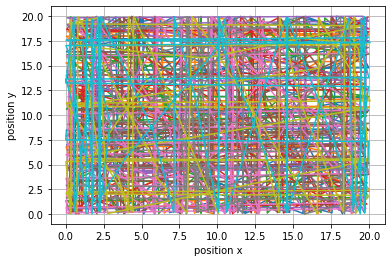

In [19]:
for data_traj_j in data_traj:
    plt.plot(data_traj_j[0],data_traj_j[1],'-')
plt.xlabel('position x')
plt.ylabel('position y')

plt.grid()
plt.show()

**Animate trajectory:**

* Set up the figure, the axis, and the plot element we want to animate

In [30]:
fig, ax = plt.subplots()

ax.set_xlim((0, box[0]))
ax.set_ylim((0, box[1]))

plt.xlabel('position x')
plt.ylabel('position y')

dot, = ax.plot([], [], 'bo', ms=5.0)

# dont show the plot 
plt.close()

* initialization function: plot the background of each frame

In [21]:
def init():
    dot.set_data([], [])
    return (dot,)

In [22]:
data_traj[:,0,1]

array([ 5.93058212, 11.67616535, 12.66715082,  3.24523579, 10.04814562,
        8.17222645,  3.66763686,  7.26457652, 14.98934188,  2.38373109])

* animation function. This is called sequentially

In [23]:
def animate(i):
    x = data_traj[:,0,i]
    y = data_traj[:,1,i]
    dot.set_data(x, y)
    return (dot,)

* call the animator. blit=True means only re-draw the parts that have changed.

In [24]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=60, blit=True)

In [25]:
HTML(anim.to_html5_video())
anim.save('animation.mp4', writer='ffmpeg', fps=30)


**Histogramming:**

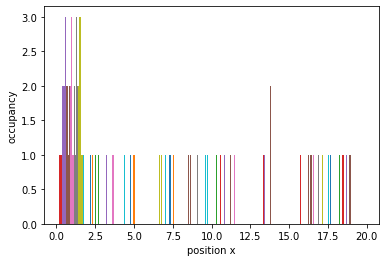

In [26]:
plt.hist(data_traj[0],range=(0,box[0]),bins=10)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

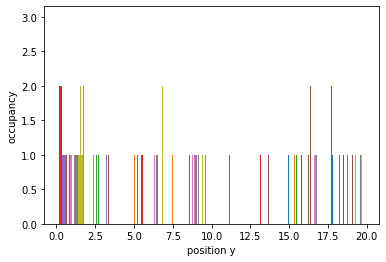

In [27]:
plt.hist(data_traj[1],range=(0,box[1]),bins=10)
plt.xlabel('position y')
plt.ylabel('occupancy')
plt.show()

ValueError: too many values to unpack (expected 2)

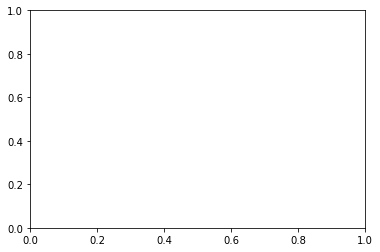

In [28]:
plt.hist2d(data_traj[0], data_traj[1], range=[[0,box[0]],[0,box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()

**Interpretation:**
* in the reduced data projection, the occupancy of each bin seems even and well-distributed
* in the full dimensional projection, it can be seen easily that the box is **not** fully sampled, large undersampled patches present
* *data dimensionality reduction always brings the danger of wrong projection!*

**Solution for improvements:**
* enhance sampling by
    * prolong the simulation
    * increase the time step
* *Caveat: all solutions come with problems like increased computational cost or sampling errors!*